In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
df = pd.read_csv("GamingStudy_data.csv", encoding = 'ISO-8859-1')
df.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

In [5]:
reduce_mem_usage(df)

Memory usage of dataframe is 5.65 MB
Memory usage after optimization is: 1.81 MB
Decreased by 67.9%


,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.003906,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.007812,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.039062,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.066406,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.089844,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13459,14246,42057.757812,1,0,0,1,0,1,1,Not difficult at all,...,France,France,Reddit,Multiplayer - online - with strangers,Accept,4,28,7.0,FRA,FRA
13460,14247,42057.812500,3,3,3,3,2,3,3,Extremely difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,20,23,25.0,USA,USA
13461,14248,42058.167969,0,0,0,0,0,0,0,Not difficult at all,...,Norway,Norway,Reddit,Multiplayer - online - with real life friends,Accept,0,32,10.0,NOR,NOR
13462,14249,42058.246094,3,2,1,3,0,1,3,Somewhat difficult,...,Canada,Canada,Reddit,Singleplayer,Accept,13,16,32.0,CAN,CAN


In [6]:
df.drop(columns=['Timestamp', 'highestleague', 'Reference', 'accept', 'Residence_ISO3', 'Birthplace_ISO3'], inplace=True)

In [7]:
df['streams'].dropna().sort_values().tail()

7615     140.0
5641     168.0
8418     200.0
9435     420.0
3860    9001.0
Name: streams, dtype: float32

In [8]:
df.loc[df['Hours'] > 160, 'Hours'] = df['Hours'].median()
df.loc[df['streams'] > 160, 'streams'] = df['streams'].median()

In [9]:
data_num_feat = df.select_dtypes(include=('int8', 'int16', 'int32', 'float32'))
data_num_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   S. No.      13464 non-null  int16  
 1   GAD1        13464 non-null  int8   
 2   GAD2        13464 non-null  int8   
 3   GAD3        13464 non-null  int8   
 4   GAD4        13464 non-null  int8   
 5   GAD5        13464 non-null  int8   
 6   GAD6        13464 non-null  int8   
 7   GAD7        13464 non-null  int8   
 8   SWL1        13464 non-null  int8   
 9   SWL2        13464 non-null  int8   
 10  SWL3        13464 non-null  int8   
 11  SWL4        13464 non-null  int8   
 12  SWL5        13464 non-null  int8   
 13  Hours       13434 non-null  float32
 14  streams     13364 non-null  float32
 15  SPIN1       13340 non-null  float32
 16  SPIN2       13310 non-null  float32
 17  SPIN3       13324 non-null  float32
 18  SPIN4       13305 non-null  float32
 19  SPIN5       13298 non-nul

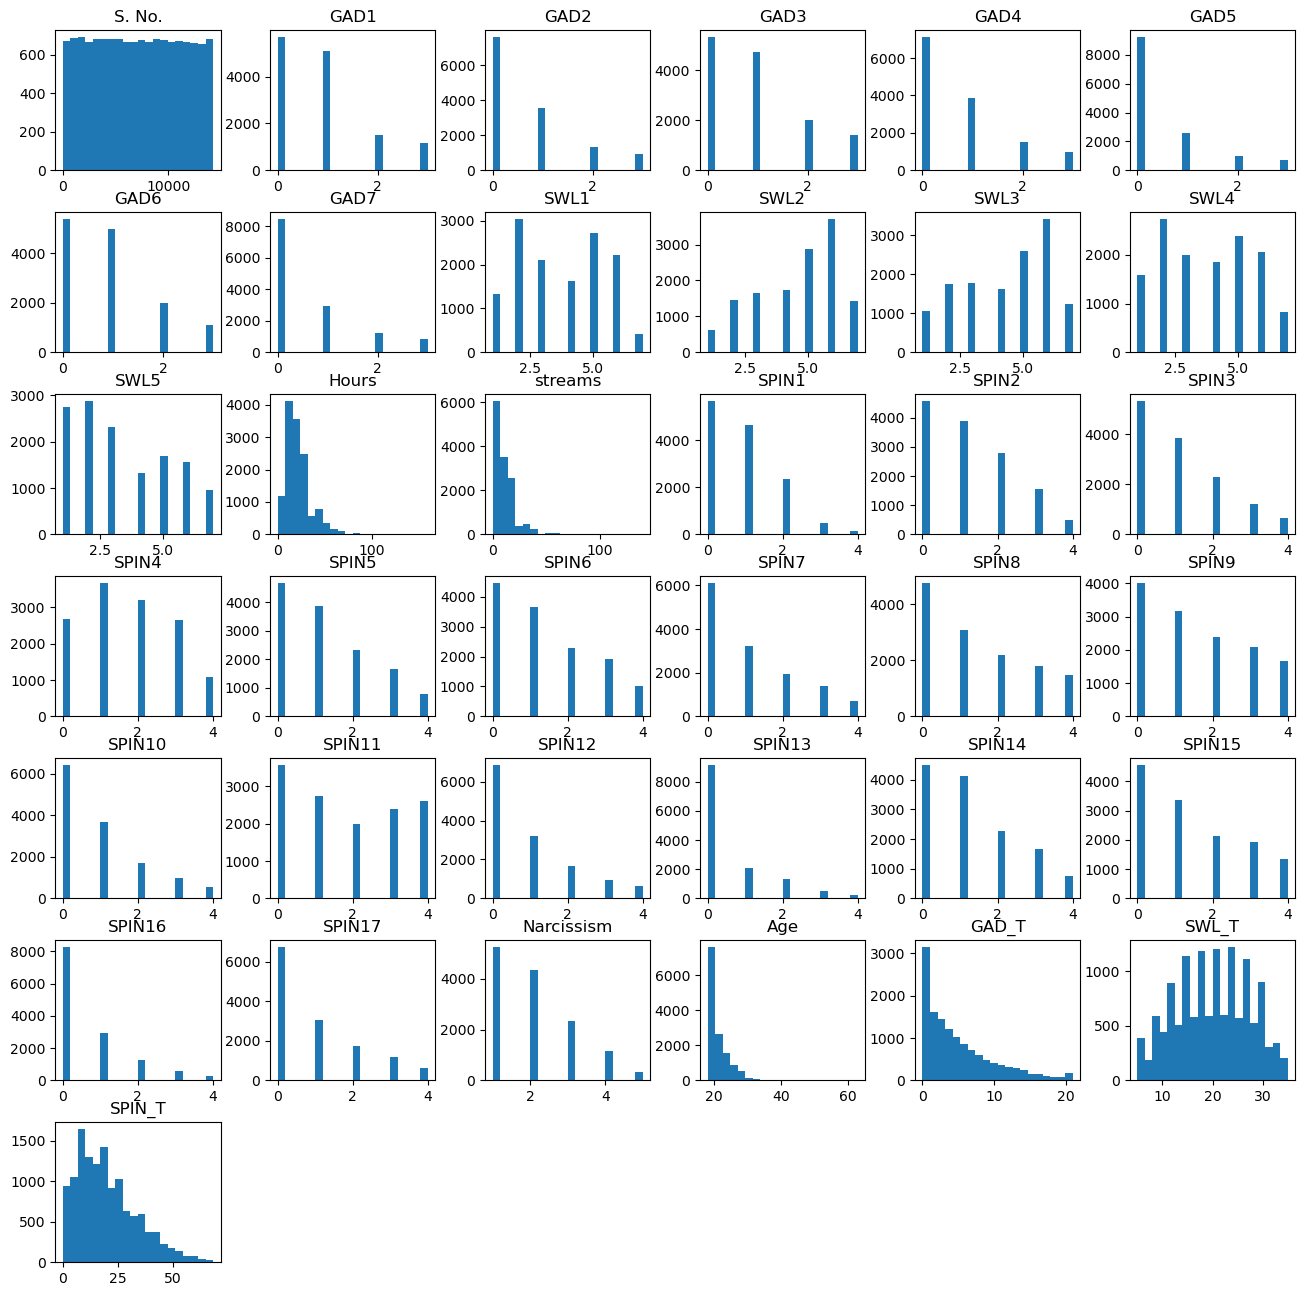

In [10]:
df.hist(figsize=(16,16), bins=20, grid=False);

In [11]:
df.League.nunique()

1455

(0.0, 1670.0)

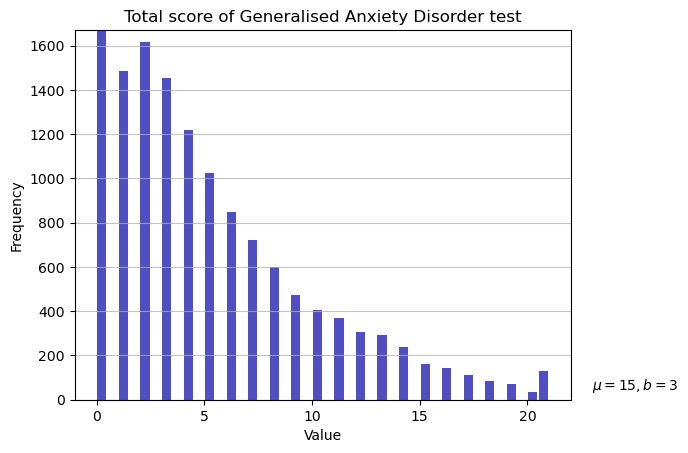

In [12]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df.GAD_T, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Generalised Anxiety Disorder test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 640.0)

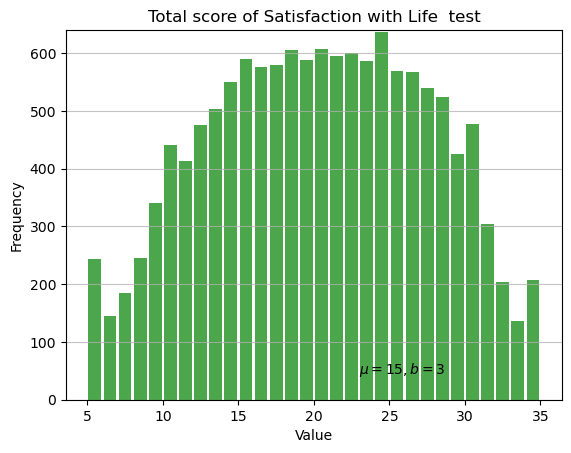

In [13]:
n, bins, patches = plt.hist(x=df.SWL_T, bins='auto', color='green',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Satisfaction with Life  test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 860.0)

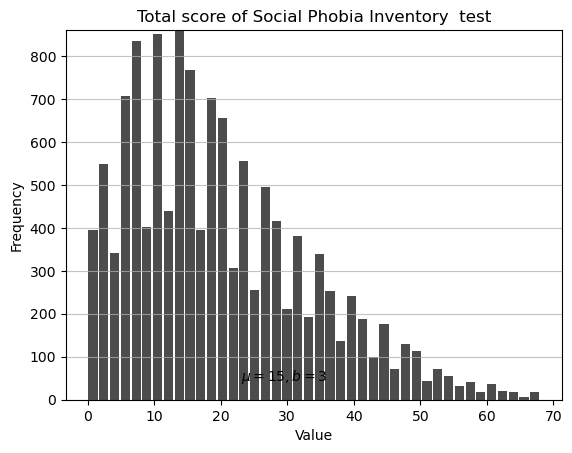

In [14]:
n, bins, patches = plt.hist(x=df.SPIN_T, bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Social Phobia Inventory  test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

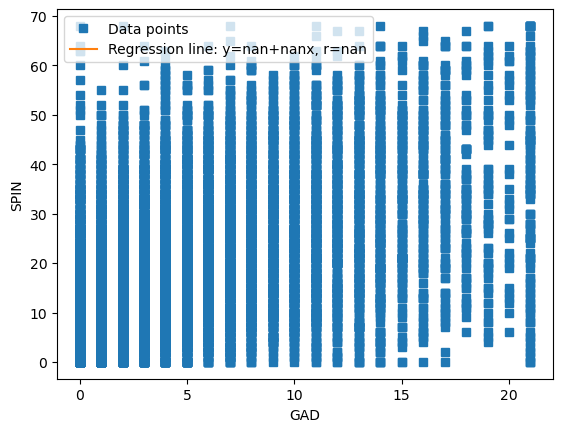

In [15]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df.GAD_T, df.SPIN_T)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(df.GAD_T, df.SPIN_T, linewidth=0, marker='s', label='Data points')
ax.plot(df.GAD_T, intercept + slope * df.GAD_T, label=line)
ax.set_xlabel('GAD')
ax.set_ylabel('SPIN')
ax.legend(facecolor='white')
plt.show()

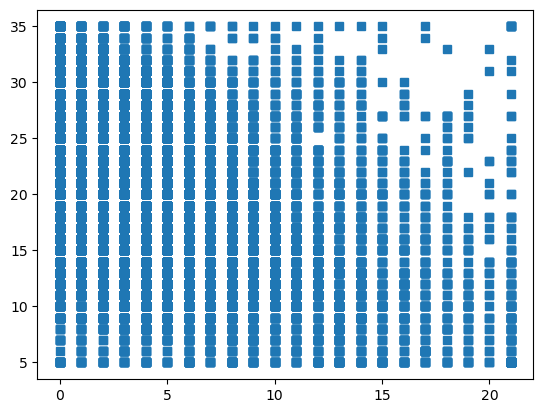

In [16]:
fig, ax = plt.subplots()
ax.plot(df.GAD_T, df.SWL_T, linewidth=0, marker='s', label='Data points')
plt.show()

In [17]:
columns_for_drop = ['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 
                    'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SPIN1', 'SPIN2',
                    'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8', 'SPIN9', 'SPIN10', 
                    'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17']

In [18]:
df.drop(columns = columns_for_drop, inplace=True)

In [19]:
df.describe()

,S. No.,Hours,streams,Narcissism,Age,GAD_T,SWL_T,SPIN_T
count,13464.000000,13434.000000,13364.000000,13441.000000,13464.000000,13464.000000,13464.000000,12814.000000
mean,7096.839201,21.623568,10.503442,2.027677,20.930407,5.211973,19.788844,19.848526
std,4114.478220,13.777575,10.232300,1.061816,3.300897,4.713267,7.229243,13.467519
min,1.000000,0.000000,0.000000,1.000000,18.000000,0.000000,5.000000,0.000000
25%,3532.750000,12.000000,4.000000,1.000000,18.000000,2.000000,14.000000,9.000000
50%,7087.500000,20.000000,8.000000,2.000000,20.000000,4.000000,20.000000,17.000000
75%,10654.250000,28.000000,15.000000,3.000000,22.000000,8.000000,26.000000,28.000000
max,14250.000000,160.000000,140.000000,5.000000,63.000000,21.000000,35.000000,68.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   S. No.      13464 non-null  int16   
 1   GADE        12815 non-null  category
 2   Game        13464 non-null  category
 3   Platform    13464 non-null  category
 4   Hours       13434 non-null  float32 
 5   earnings    13464 non-null  category
 6   whyplay     13464 non-null  category
 7   League      11626 non-null  category
 8   streams     13364 non-null  float32 
 9   Narcissism  13441 non-null  float32 
 10  Gender      13464 non-null  category
 11  Age         13464 non-null  int8    
 12  Work        13426 non-null  category
 13  Degree      13464 non-null  category
 14  Birthplace  13464 non-null  category
 15  Residence   13464 non-null  category
 16  Playstyle   13464 non-null  category
 17  GAD_T       13464 non-null  int8    
 18  SWL_T       13464 non-null  int8    
 19  SPIN

array([[<Axes: title={'center': 'S. No.'}>,
        <Axes: title={'center': 'Hours'}>,
        <Axes: title={'center': 'streams'}>],
       [<Axes: title={'center': 'Narcissism'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'GAD_T'}>],
       [<Axes: title={'center': 'SWL_T'}>,
        <Axes: title={'center': 'SPIN_T'}>, <Axes: >]], dtype=object)

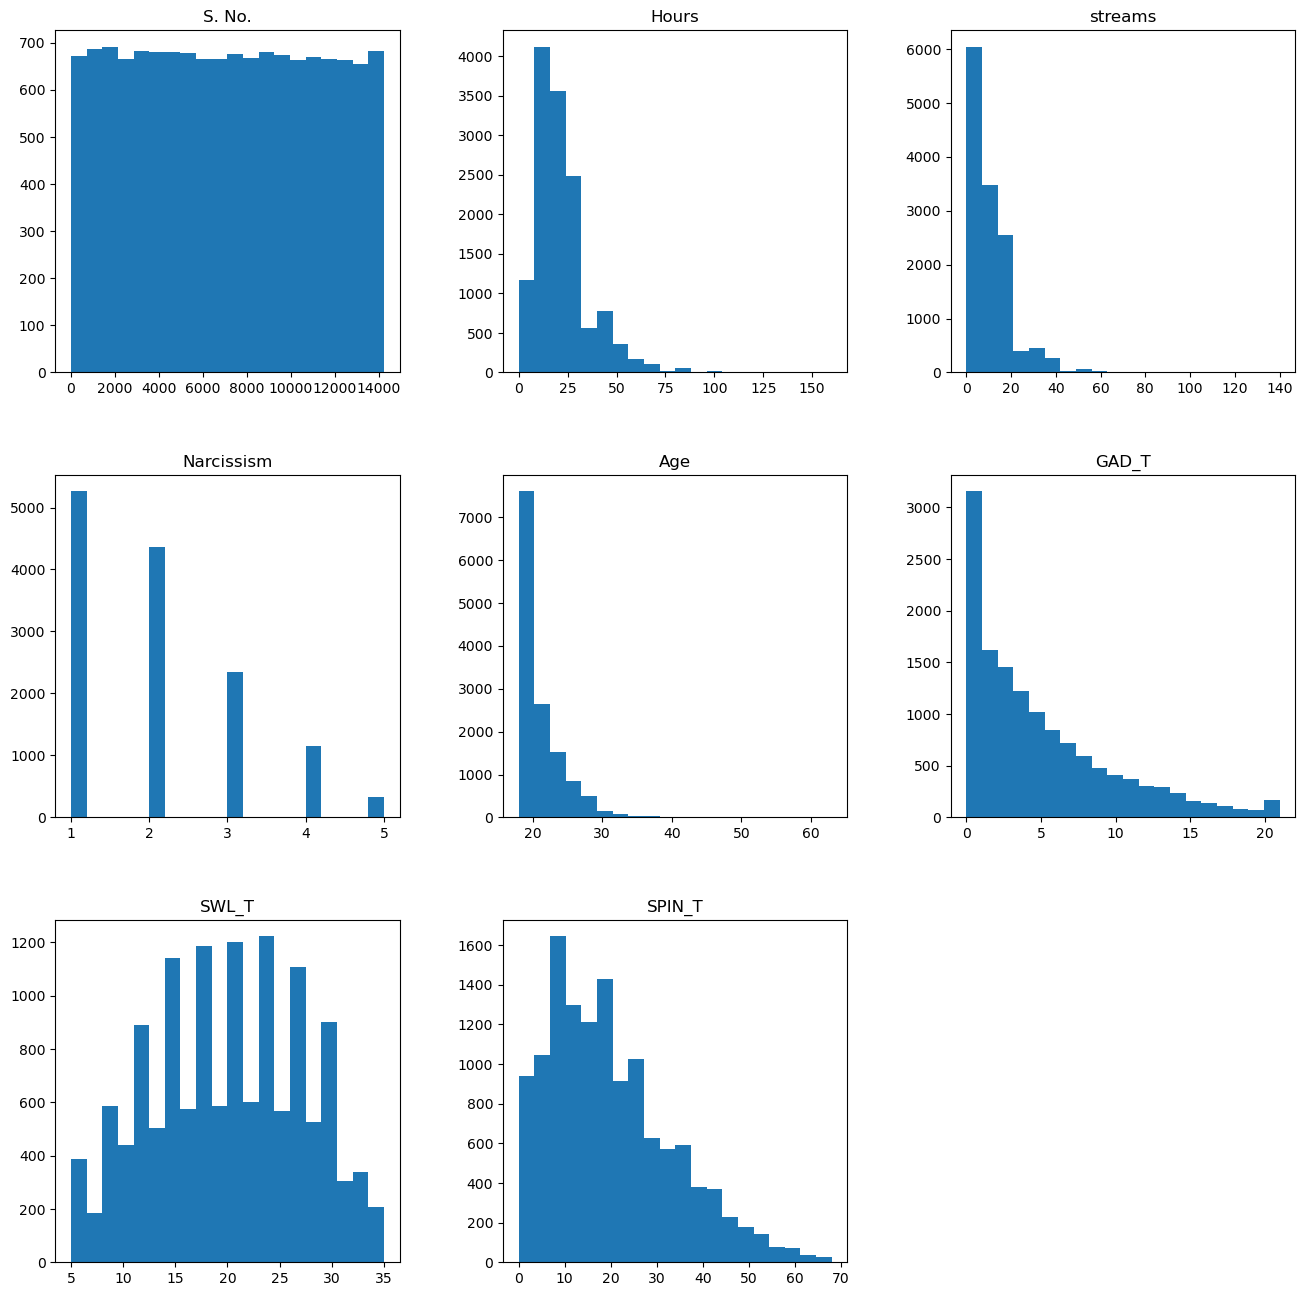

In [21]:
df.hist(figsize=(16,16), bins=20, grid=False)

/tmp/ipykernel_4706/658433077.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


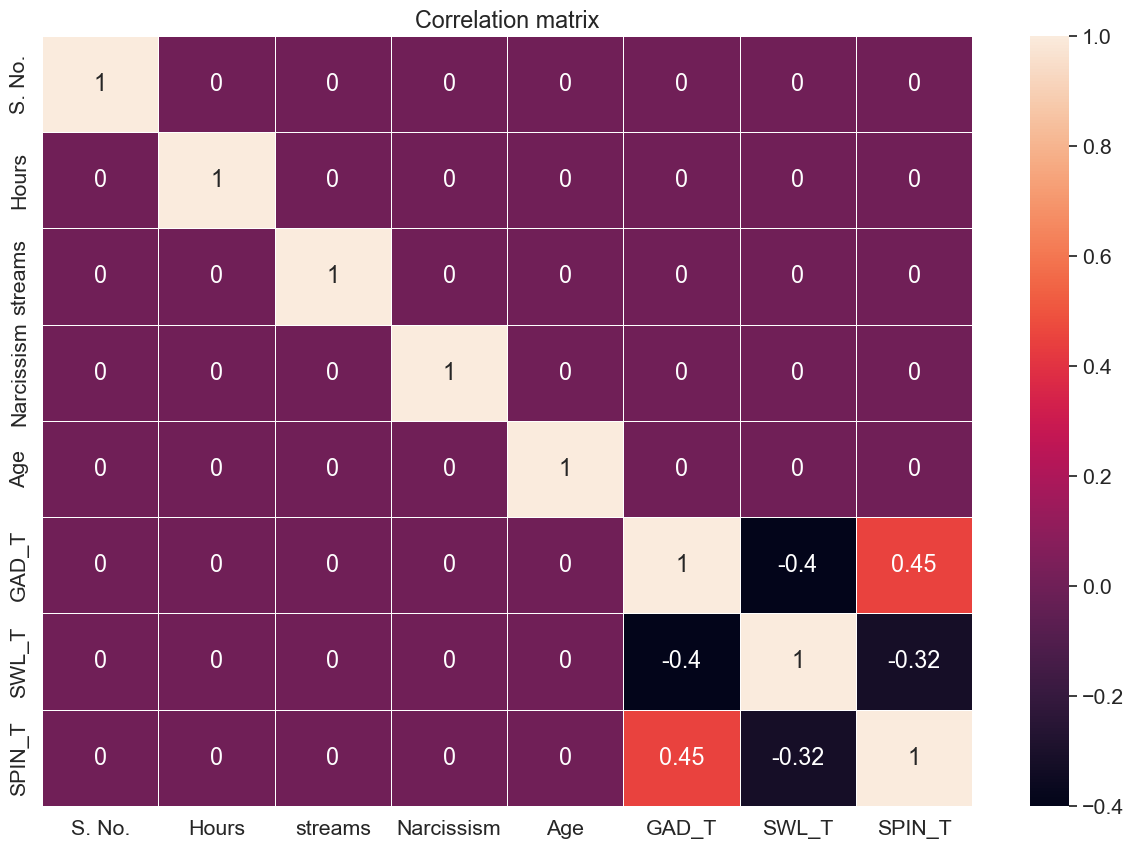

In [22]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='rocket')
plt.title('Correlation matrix')
plt.show()

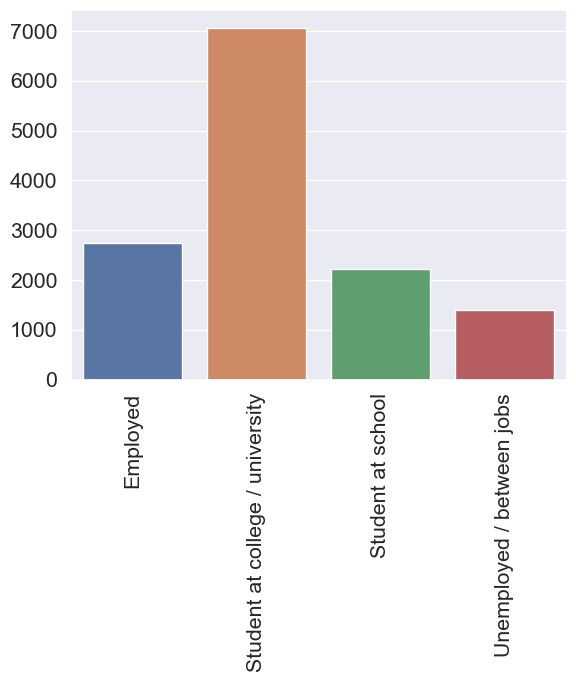

In [23]:
barplt = sns.barplot(x=df['Work'].value_counts().index, y=df['Work'].value_counts().values)
for label in barplt.get_xticklabels():
    label.set_rotation(90)
plt.show()

### Избавляемся от NaN

In [24]:
df.isna().sum()

S. No.           0
GADE           649
Game             0
Platform         0
Hours           30
earnings         0
whyplay          0
League        1838
streams        100
Narcissism      23
Gender           0
Age              0
Work            38
Degree           0
Birthplace       0
Residence        0
Playstyle        0
GAD_T            0
SWL_T            0
SPIN_T         650
dtype: int64

In [25]:
df.GADE.fillna(df.GADE.value_counts().index[1] , inplace=True)
df.Hours.fillna(df.Hours.mean() , inplace=True)
df.streams.fillna(df.streams.mean() , inplace=True)
df.League.fillna(df.League.value_counts().index[1] , inplace=True)
df.Narcissism.fillna(df.Narcissism.value_counts().index[1] , inplace=True)
df.Work.fillna(df.Work.value_counts().index[1] , inplace=True)

In [26]:
df.isna().sum()

S. No.          0
GADE            0
Game            0
Platform        0
Hours           0
earnings        0
whyplay         0
League          0
streams         0
Narcissism      0
Gender          0
Age             0
Work            0
Degree          0
Birthplace      0
Residence       0
Playstyle       0
GAD_T           0
SWL_T           0
SPIN_T        650
dtype: int64

In [32]:
df['target'] = np.where(df['GAD_T'] > 10, 1, 0)

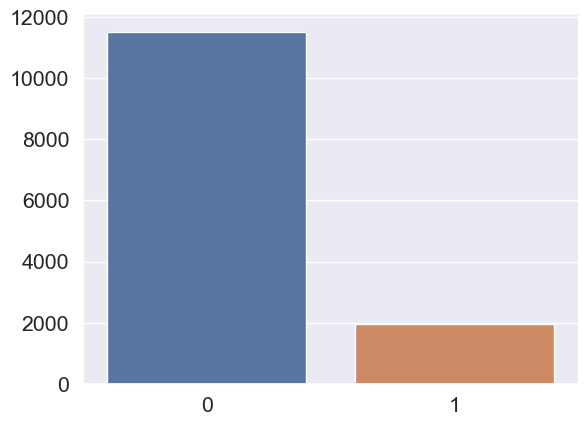

In [41]:
sns.barplot(x=df['target'].value_counts().index, y=df['target'].value_counts().values)
plt.show()

In [28]:
cat_columns = ['GADE', 'GAME', 'Platform', 'Gender', 'Work', 'Degree']

In [38]:
df.drop(columns=['GAD_T', 'SWL_T', 'SPIN_T', 'S. No.'], inplace=True)

Пока дропнем столбцы с текстом, пока я не придумаю, что с ними делать

In [44]:
df.drop(columns=['earnings', 'whyplay', 'League', 'Playstyle'], inplace=True)

Города тоже дропнем, не знаю, как их лучше обработать

In [62]:
df.drop(columns=['Birthplace', 'Residence'], inplace=True)

In [63]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], random_state=0)

In [64]:
X_train

,GADE,Game,Platform,Hours,streams,Narcissism,Gender,Age,Work,Degree
204,Not difficult at all,League of Legends,PC,14.0,10.0,1.0,Male,19,Student at college / university,High school diploma (or equivalent)
466,Not difficult at all,Other,PC,20.0,5.0,1.0,Male,20,Employed,High school diploma (or equivalent)
9942,Somewhat difficult,League of Legends,PC,24.0,5.0,5.0,Male,19,Student at college / university,High school diploma (or equivalent)
11268,Not difficult at all,League of Legends,PC,18.0,2.0,2.0,Male,18,Student at school,None
175,Somewhat difficult,Destiny,"Console (PS, Xbox, ...)",14.0,1.0,1.0,Male,29,Employed,"Ph.D., Psy. D., MD (or equivalent)"
...,...,...,...,...,...,...,...,...,...,...
13123,Not difficult at all,League of Legends,PC,50.0,1.0,1.0,Male,20,Student at college / university,High school diploma (or equivalent)
3264,Not difficult at all,League of Legends,PC,20.0,25.0,3.0,Male,18,Unemployed / between jobs,High school diploma (or equivalent)
9845,Very difficult,League of Legends,PC,7.0,1.0,4.0,Male,18,Student at school,None
10799,Somewhat difficult,League of Legends,PC,20.0,4.0,3.0,Male,18,Student at school,High school diploma (or equivalent)


In [65]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10098 entries, 204 to 2732
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GADE        10098 non-null  category
 1   Game        10098 non-null  category
 2   Platform    10098 non-null  category
 3   Hours       10098 non-null  float32 
 4   streams     10098 non-null  float32 
 5   Narcissism  10098 non-null  float32 
 6   Gender      10098 non-null  category
 7   Age         10098 non-null  int8    
 8   Work        10098 non-null  category
 9   Degree      10098 non-null  category
dtypes: category(6), float32(3), int8(1)
memory usage: 267.5 KB


In [67]:
continuous_columns = ["Hours", "streams", 'Narcissism', 'Age']
cat_columns = ['GADE', 'Game', 'Platform', 'Gender', 'Work', 'Degree']
final_transformers = list()

In [68]:
for cat_col in cat_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [69]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [70]:
feats

FeatureUnion(transformer_list=[('GADE',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='GADE')),
                                                ('ohe',
                                                 OHEEncoder(key='GADE'))])),
                               ('Game',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Game')),
                                                ('ohe',
                                                 OHEEncoder(key='Game'))])),
                               ('Platform',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Platform')),
                                                ('ohe',
                                                 OHEEncoder(key='Platform'))])),
                               (...
                                                 NumberSelector(key='Hours')),
                                                ('scaler', StandardScaler())])),
                               ('streams',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='streams')),
                                                ('scaler', StandardScaler())])),
                               ('Narcissism',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='Narcissism')),
                                                ('scaler', StandardScaler())])),
                               ('Age',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='Age')),
                                                ('scaler',
                                                 StandardScaler())]))])

In [71]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('GADE',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='GADE')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='GADE'))])),
                                                ('Game',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Game')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Game'))])),
                                                ('Platform',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Platform')),
                                                                 ('ohe',
                                                                  OHEE...
                                                ('streams',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='streams')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Narcissism',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Narcissism')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [79]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
#     plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.913
RMSE:	0.104
MSE:	0.011


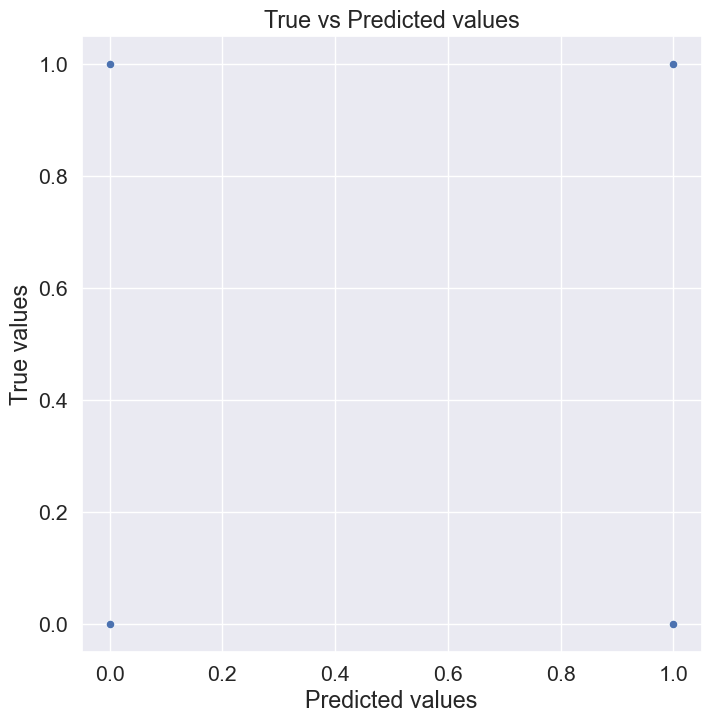

In [80]:
y_train_preds = pipeline.predict(X_train)
evaluate_preds(y_train, y_train_preds)